# Import Packages

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import OLSInfluence

# Setup basic configuration + define helper functions

In [2]:
def write_to_file(file_name, content):
    with open(file_name, 'w') as f:
        f.write(content)


# Create directory for output files
Path('tmp/out').mkdir(parents=True, exist_ok=True)

# Set dark theme
plt.style.use('dark_background')

# Set grid thickness
plt.rcParams['grid.linewidth'] = 0.3

# Load Data

In [3]:
excel_file = pd.ExcelFile("Projekt-2_Data.xlsx")
df_uloha_1: pd.DataFrame = excel_file.parse(excel_file.sheet_names[0])
df_uloha_2 = excel_file.parse(excel_file.sheet_names[1])
data = {
    '1': df_uloha_1,
    '1_a': df_uloha_1['uloha_1 a)'],
    '1_b_prior': df_uloha_1['uloha_1 b)_prior'],
    '1_g': df_uloha_1['skupina'],
    '1_b_observation': df_uloha_1['uloha_1 b)_pozorování'],
    '2': df_uloha_2,
    '2_os': df_uloha_2['OSType'],
    '2_as': df_uloha_2['ActiveUsers'],
    '2_ip': df_uloha_2['InteractingPct'],
    '2_sp': df_uloha_2['ScrollingPct'],
    '2_p': df_uloha_2['Ping [ms]'],
}
# data

# TASK 1 - Bayesian estimates

## TASK 1.a - Conjugate a priori and a posteriori distributions, predictive distribution [2 points]

### Clean data
- Remove outliers
- Remove nan values
- Remove +-inf values
- Remove values with Z-score > 3
- Remove values with Z-score < -3

In [4]:
df_uloha_1 = data['1_a']

# Extract observed data
observed_data = df_uloha_1.values

# Remove nan or +-inf values
observed_data = observed_data[~np.isnan(observed_data)]

# Calculate Z-scores
z_scores = stats.zscore(observed_data, nan_policy='raise')

# Define a threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Filter out rows with Z-scores beyond the threshold
filtered_data = observed_data[(np.abs(z_scores) < threshold)]
filtered_data

array([2., 2., 1., 3., 0., 1., 1., 3., 2., 2., 3., 1., 5., 3., 1., 1., 2.,
       1., 1., 1., 2., 3., 2., 0., 3., 1., 2., 1., 5., 1., 0., 0., 2., 1.,
       1., 0., 0., 1., 3., 1., 0., 1., 2., 0., 1., 3., 0., 1., 1., 4., 1.,
       2., 1., 1., 2., 4., 2., 2., 3., 4., 4., 4., 0., 2., 0., 0., 3., 5.,
       1., 2., 1., 0., 1., 1., 4., 1., 1., 3., 0., 1., 2., 2., 2., 3., 1.,
       2., 2., 2., 1., 2., 2., 1., 0., 1., 1., 3., 0., 3., 1., 1.])

## TASK 1.a.1 - Plot the a priori and aposteriori densities of the Poisson distribution $\lambda$ in one figure.

In [5]:
alpha_prior = 10  # connection count
beta_prior = 5  # time within the connection count (alpha_prior) was observed
lambda_expert = alpha_prior / beta_prior  # expert's estimate of the connection count

In [6]:
alpha_posterior = alpha_prior + np.sum(filtered_data)
beta_posterior = beta_prior + len(filtered_data)

In [7]:
x_prior = np.linspace(0, np.max(filtered_data), 1000)
y_prior = stats.gamma.pdf(x_prior, alpha_prior, scale=1 / beta_prior)

In [8]:
x_posterior = np.linspace(0, np.max(filtered_data), 1000)
y_posterior = stats.gamma.pdf(x_posterior, alpha_posterior, scale=1 / beta_posterior)

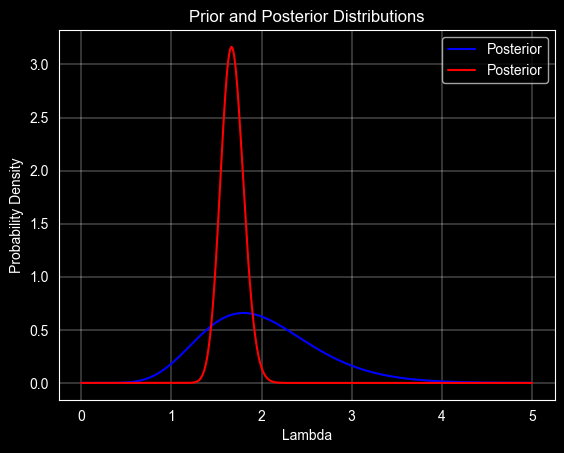

In [9]:
plt.plot(x_prior, y_prior, label='Posterior', color='blue')
plt.plot(x_posterior, y_posterior, label='Posterior', color='red')
plt.title('Prior and Posterior Distributions')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

## TASK 1.a.2 - Plot the a priori and aposteriori predictive densities of observations $x$ over one time interval in one figure.

In [10]:
x_prior_interval = range(0, 6)  # 0 to 5 connections, because nbinom is discrete
y_prior_interval = stats.nbinom.pmf(x_prior_interval, alpha_prior, beta_prior / (1 + beta_prior))

In [11]:
x_posterior_interval = range(0, 6)  # 0 to 5 connections, because nbinom is discrete
y_posterior_interval = stats.nbinom.pmf(x_posterior_interval, alpha_posterior, beta_posterior / (1 + beta_posterior))

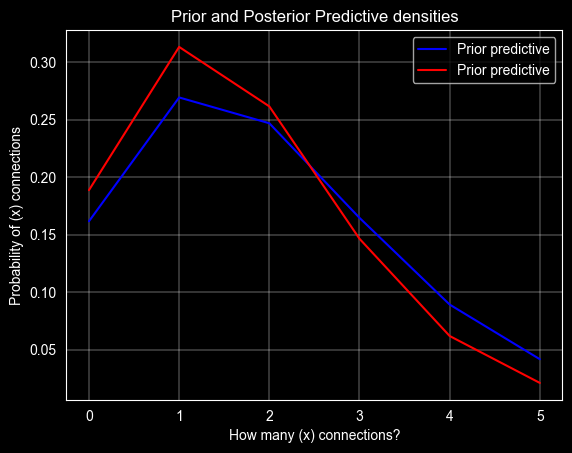

In [12]:
plt.plot(x_prior_interval, y_prior_interval, label='Prior predictive', color='blue')
plt.plot(x_posterior_interval, y_posterior_interval, label='Prior predictive', color='red')
plt.title('Prior and Posterior Predictive densities')
plt.xlabel('How many (x) connections?')
plt.ylabel('Probability of (x) connections')
plt.legend()
plt.show()

In [13]:
# Task 3: Construct 95% confidence intervals for λ from prior and posterior distributions
prior_ci = stats.gamma.interval(0.95, alpha_prior, scale=1 / beta_prior)
posterior_ci = stats.gamma.interval(0.95, alpha_posterior, scale=1 / beta_posterior)
print(f"Prior 95% CI: {prior_ci[0]:.5f}, {prior_ci[1]:.5f}")
print(f"Posterior 95% CI: {posterior_ci[0]:.5f}, {posterior_ci[1]:.5f}")

Prior 95% CI: 0.95908, 3.41696
Posterior 95% CI: 1.43769, 1.93272


In [14]:
# Task 4: Select two posterior point estimates for λ and compare them
posterior_mean = alpha_posterior / beta_posterior
posterior_mode = (alpha_posterior - 1) / beta_posterior
print(f"Aposteriori mean: {posterior_mean:.5f}")
print(f"Aposteriori mode: {posterior_mode:.5f}")

Aposteriori mean: 1.67619
Aposteriori mode: 1.66667


In [15]:
# Task 5: Select one prior and one posterior point estimate for the number of observations
mu_prior = alpha_prior / beta_prior
mu_posterior = alpha_posterior / beta_posterior
print(f"Prior estimate: {mu_prior:.5f}")
print(f"Posterior estimate: {mu_posterior:.5f}")

Prior estimate: 2.00000
Posterior estimate: 1.67619


## TASK 1.b - Approximation by discrete distribution [2 points]

In [16]:
mu = 3
sigma = np.sqrt(1)
a = 1

### Load data

In [17]:
# Cleaned data
df_uloha_1_b = {
    'prior_data': data['1_b_prior'][~np.isnan(data['1_b_prior'])],
    'observed_data': data['1_b_observation'][~np.isnan(data['1_b_observation'])],
    'group_column': data['1_g'][~np.isnan(data['1_g'])]
}
observed_data = df_uloha_1_b['observed_data']

### TASK 1.b.1: Plot prior, posterior, and likelihood functions

In [18]:
bins_count = 50

# Get max value for each group
all_data_max = data['1'].groupby('skupina')['uloha_1 b)_prior'].max()

bin_width = (all_data_max.max() - all_data_max.min()) / bins_count  # Get bin width
bins = np.arange(all_data_max.min(), all_data_max.max(), bin_width)  # Bin values

bin_height, bin_edges = np.histogram(all_data_max, bins=bins_count)
bin_height = bin_height / np.sum(bin_height)

# Plot bins
# plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.7)
# plt.show()

In [19]:
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


def likelyhood_func(observed_data, b):
    """
    Calculate likelyhood function
    :param observed_data: 
    :param b: 
    :return: 
    """
    a_truncnorm = (a - mu) / sigma
    b_truncnorm = (b - mu) / sigma
    pdf = stats.truncnorm.pdf(observed_data, a=a_truncnorm, b=b_truncnorm, loc=mu, scale=sigma)
    return pdf


# Calculate likelyhood function for each bin
likelihood = [likelyhood_func(observed_data, b_center) for b_center in bin_centers]

# Calculate product of all likelyhoods
likelihood = np.prod(likelihood, axis=1)

# Normalize likelyhood
likelihood_normalized = likelihood / np.sum(likelihood)

# Plot likelyhood
# plt.bar(x=bins, height=likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelyhood', alpha=0.7)
# plt.show()

In [20]:
# Calculate posterior
posterior_probs = likelihood * bin_height
posterior_probs_normalized = posterior_probs / np.sum(posterior_probs)

# plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green', label='Aposteriórne rozdelenie', alpha=0.7)
# plt.show()

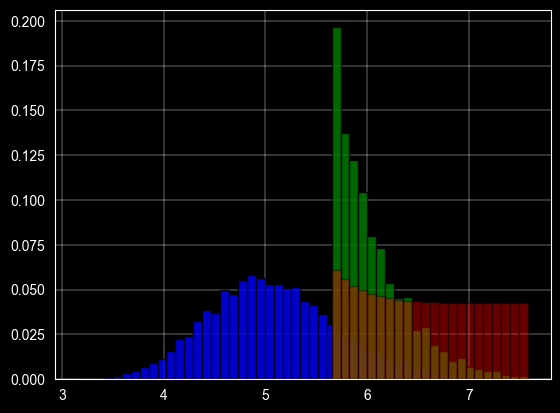

In [21]:
# Plot all together: prior, likelyhood, posterior
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.8, edgecolor='black')
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green',
        label='Aposteriórne rozdelenie', alpha=0.8)
plt.bar(bin_centers, likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Vierohodnosť',
        alpha=0.4)
plt.show()

### TASK 1.b.2. From the aposteriori density, determine the 95% confidence interval (confidence interval) for the parameter 𝑏.

In [22]:
# Calculate 95% confidence interval
cumulative_posterior = np.cumsum(posterior_probs_normalized)
lower_bound = bin_centers[np.argmax(cumulative_posterior >= 0.025)]
upper_bound = bin_centers[np.argmin(cumulative_posterior <= 0.975)]
print(f'95% Confidence Interval for Parameter b: {lower_bound:.5f}, {upper_bound:.5f}')

95% Confidence Interval for Parameter b: 5.69371, 7.00891


### TASK 1.b.3. Choose two point estimates of 𝑏 and calculate them.

In [23]:
# Calculate point estimates
mean = np.sum(bin_centers * posterior_probs_normalized)
median = bin_centers[np.argmax(posterior_probs_normalized)]
print(f'First point estimate: {mean:.5f}')
print(f'Second point estimate: {median:.5f}')  # Is this value OK?

First point estimate: 6.05277
Second point estimate: 5.69371


# TASK 2 - Regression - 8. points

## TASK 2.1. Use backward elimination to determine the appropriate regression model. Consider the default "full" model to be the full quadratic model (all second order interactions and all squares that make sense). [4. points] 

### Learn more about data

In [24]:
# Load data
df_uloha_2 = data['2']

# Print data info to learn more about data
print(df_uloha_2.head())
print()
print(df_uloha_2.describe())

    OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0      iOS         4113          0.8283        0.1717         47
1      iOS         7549          0.3461        0.6539         46
2  Windows         8855          0.2178        0.7822         55
3  Android         8870          0.0794        0.9206         56
4    MacOS         9559          0.7282        0.2718         76

       ActiveUsers  InteractingPct  ScrollingPct   Ping [ms]
count   502.000000      502.000000    502.000000  502.000000
mean   5485.830677        0.488613      0.511387   50.545817
std    2548.935679        0.296000      0.296000   14.797937
min     153.000000        0.000500      0.001400   11.000000
25%    3357.500000        0.229300      0.257525   40.000000
50%    5456.000000        0.482950      0.517050   52.000000
75%    7461.500000        0.742475      0.770700   60.000000
max    9953.000000        0.998600      0.999500   90.000000


### Visualize data using matrix plot

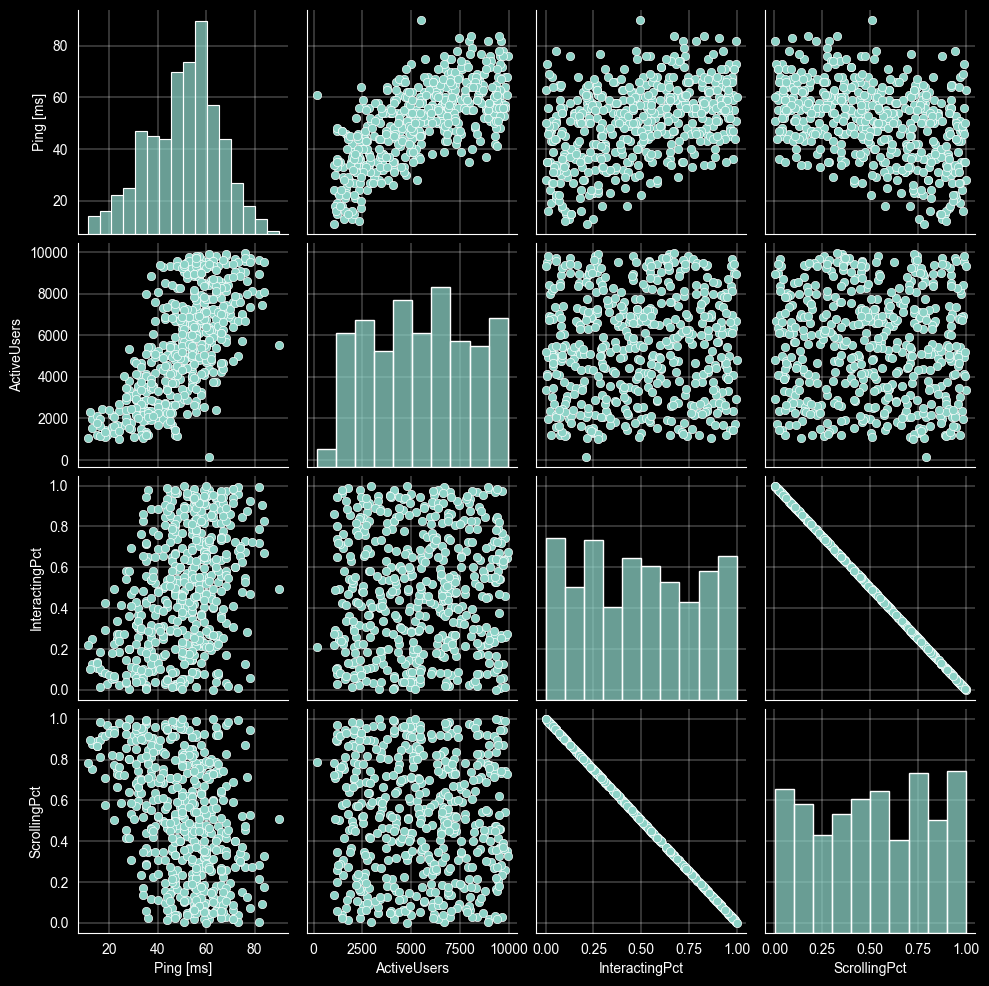

In [25]:
# Visualize data
ax = sns.pairplot(df_uloha_2[['Ping [ms]', 'ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()

Based on the previos correlation matrix, we can see that there is a high correlation between InteractingPct and ScrollingPct. Therefore we can remove one of them.

I choose to remove __ScrollingPct__

In [26]:
# Remove correlated parameters
X = pd.DataFrame({
    'ActiveUsers': df_uloha_2.loc[:, 'ActiveUsers'],
    'InteractingPct': df_uloha_2.loc[:, 'InteractingPct'],
    'ScrollingPct': df_uloha_2.loc[:, 'ScrollingPct'],
    "Windows": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Windows' else 0),
    "iOS": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'iOS' else 0),
    "MacOS": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'MacOS' else 0),
    "Android": df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Android' else 0),
})

In [27]:
# Standardize data
X['ActiveUsers'] = (X['ActiveUsers'] - X['ActiveUsers'].mean()) / X['ActiveUsers'].std()
X['InteractingPct'] = (X['InteractingPct'] - X['InteractingPct'].mean()) / X['InteractingPct'].std()
X['ScrollingPct'] = (X['ScrollingPct'] - X['ScrollingPct'].mean()) / X['ScrollingPct'].std()

# These are categorical variables, so we don't need to standardize them
# X['Windows'] = (X['Windows'] - X['Windows'].mean()) / X['Windows'].std()
# X['iOS'] = (X['iOS'] - X['iOS'].mean()) / X['iOS'].std()
# X['MacOS'] = (X['MacOS'] - X['MacOS'].mean()) / X['MacOS'].std()
# X['Android'] = (X['Android'] - X['Android'].mean()) / X['Android'].std()

In [28]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(X.values.T)
corr_params = np.abs(correlation_matrix) > 0.7

# Print all correlated parameters that are not on the main diagonal and those only above main diagonal
print("Correlated parameters:")
for i in range(corr_params.shape[0]):
    for j in range(corr_params.shape[1]):
        if i != j and i < j and corr_params[i, j]:
            print(f"{X.columns[i]} - {X.columns[j]}")
            print(f"Removing {X.columns[j]}")
            X = X.drop(X.columns[j], axis=1)
X.head()

Correlated parameters:
InteractingPct - ScrollingPct
Removing ScrollingPct


,ActiveUsers,InteractingPct,Windows,iOS,MacOS,Android
0,-0.538590,1.147592,0,1,0,0
1,0.809424,-0.481464,0,1,0,0
2,1.321795,-0.914910,1,0,0,0
3,1.327679,-1.382478,0,0,0,1
4,1.597988,0.809416,0,0,1,0


In [29]:
# Polynomial degree
degree = 2

# Use PolynomialFeatures
poly = PolynomialFeatures(degree=degree, include_bias=True)
poly_features = poly.fit_transform(X)

# Create a new dataframe with the polynomial features and original column names
poly_X = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(X.columns))

# Rename 1 to const
poly_X.rename(columns={'1': 'const'}, inplace=True)
# poly_X

In [30]:
def get_column_to_remove(model):
    """
    Firstly get all quadratic columns ending with ^2, then remove interaction terms and after all linear terms
    :param model: 
    :return: 
    """
    pvalues = model.pvalues

    # Find all columns with p-value > 0.05 and nan
    pvalues = pvalues[(pvalues > 0.05) | (pvalues.isna())]
    pvalues = pvalues.drop('const') if 'const' in pvalues else pvalues

    # Check if there is any quadratic term
    quadratic_terms = [i for i in pvalues.index if i.endswith('^2')]

    # Check if there is any interaction term
    interaction_terms = [i for i in pvalues.index if ' ' in i]

    # Check if there is any linear term
    linear_terms = [i for i in pvalues.index if i not in quadratic_terms and i not in interaction_terms]

    # Find nan values
    nan_values = [i for i in pvalues.index if
                  i not in quadratic_terms and i not in interaction_terms and i not in linear_terms]

    if len(quadratic_terms) > 0:
        return quadratic_terms[0]
    elif len(interaction_terms) > 0:
        return interaction_terms[0]
    elif len(linear_terms) > 0:
        return linear_terms[0]
    elif len(nan_values) > 0:
        return nan_values[0]
    else:
        return None

In [31]:
# Train
y = df_uloha_2['Ping [ms]']
model = sm.OLS(endog=y, exog=poly_X).fit()

# Remove from poly_X the values that has p-value >= 0.05
while remove_col := get_column_to_remove(model):
    print(f"Removing {remove_col}")
    poly_X = poly_X.drop(remove_col, axis=1)  # remove column from X
    model = sm.OLS(endog=y, exog=poly_X).fit()  # fit model again

# Print summary
print(model.summary())
write_to_file('tmp/out/model_summary_pvalue.txt', model.summary().as_text())

Removing InteractingPct^2
Removing ActiveUsers Windows
Removing ActiveUsers iOS
Removing InteractingPct Android
Removing InteractingPct Windows
Removing InteractingPct iOS
Removing InteractingPct MacOS
Removing Windows iOS
Removing Windows MacOS
Removing Windows Android
Removing iOS MacOS
Removing iOS Android
Removing MacOS Android
                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        01:24:57   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     492   BIC:                             3261.
Df Model:                         

In [32]:
def get_column_to_remove_vif(df):
    """
    Firstly get all quadratic columns ending with ^2, then remove interaction terms and after all linear terms
    :param model: 
    :return: 
    """
    # Calculate vif
    vif = pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

    # Remove all values above 5 (infinite included), const can not be removed
    vif = vif[vif > 5]

    # Don't remove const
    vif = vif.drop('const') if 'const' in vif else vif

    # Check if there is any quadratic term
    quadratic_terms = [i for i in vif.index if i.endswith('^2')]

    # Check if there is any interaction term
    interaction_terms = [i for i in vif.index if ' ' in i]

    # Check if there is any linear term
    linear_terms = [i for i in vif.index if i not in quadratic_terms and i not in interaction_terms]

    # Find nan values
    nan_values = [i for i in vif.index if
                  i not in quadratic_terms and i not in interaction_terms and i not in linear_terms]

    if len(quadratic_terms) > 0:
        return quadratic_terms[0]
    elif len(interaction_terms) > 0:
        return interaction_terms[0]
    elif len(linear_terms) > 0:
        return linear_terms[0]
    elif len(nan_values) > 0:
        return nan_values[0]
    else:
        return None

In [33]:
import warnings

# Ignore warnings, because of division by zero when calculating vif
warnings.simplefilter("ignore", category=RuntimeWarning)

# Remove all parameters that has vif >= 5 (infinite included), const can not be removed
while remove_col := get_column_to_remove_vif(poly_X):
    print(f"Removing {remove_col}")
    poly_X = poly_X.drop(remove_col, axis=1)
    model = sm.OLS(endog=y, exog=poly_X).fit()

# Reset warnings to default
warnings.resetwarnings()

# Print summary
print(model.summary())
write_to_file('tmp/out/model_summary_vif.txt', model.summary().as_text())

# Calculate VIF
vif = pd.Series([variance_inflation_factor(poly_X.values, i) for i in range(poly_X.shape[1])], index=poly_X.columns)
vif

Removing Windows^2
Removing iOS^2
Removing MacOS^2
Removing Android^2
Removing Windows
                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     293.7
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.62e-191
Time:                        01:24:57   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3219.
Df Residuals:                     492   BIC:                             3261.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

const                         5.006291
ActiveUsers                   1.929304
InteractingPct                1.013519
iOS                           1.446080
MacOS                         1.481309
Android                       1.440922
ActiveUsers^2                 1.013961
ActiveUsers InteractingPct    1.016595
ActiveUsers MacOS             1.527704
ActiveUsers Android           1.416742
dtype: float64

In [34]:
## ULOHA 2.1. [4. points] Use backward elimination to determine the appropriate regression model. Consider the default "full" model to be the full quadratic model (all second order interactions and all squares that make sense).


### TASK 2.1.1 Write the equation of your final model.

In [35]:
# Print equation
model_params = model.params.drop('const')
equation = f"ping = \n{model.params['const']:.5f}\n"
for k, v in model_params.items():
    equation += f"+ {v:.5f} * {k}\n"
print(equation)

ping = 
54.85603
+ 7.78621 * ActiveUsers
+ 5.04932 * InteractingPct
+ -9.58693 * iOS
+ 5.53933 * MacOS
+ -3.87321 * Android
+ -2.68377 * ActiveUsers^2
+ -2.31866 * ActiveUsers InteractingPct
+ 5.84648 * ActiveUsers MacOS
+ 2.22559 * ActiveUsers Android


### TASK 2.1.2 Discuss meeting the assumptions of linear regression and basic regression diagnostics.
TODO

### TASK 2.1.3 If (during regression modelling) you identify some "extreme outliers" you can discard the "outliers" after at least a short justification.
TODO

In [36]:
def plot_diagnostic_subplots(model, title: str = 'Diagnostic Plots'):
    """
    Plot diagnostic subplots
    :param model:
    :param title:
    :return:
    """
    # Set up subplots
    fig, axes = plt.subplots(1, 4, figsize=(4 * 4, 4))

    # Set title for whole plots
    fig.suptitle(title, fontsize=16)

    # Residua vs. Fitted Values (diagnostic graph)
    sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[0])
    axes[0].set_title("Residua vs. Fitted Values")
    axes[0].set_xlabel("Fitted Values")
    axes[0].set_ylabel("Residua")

    # Normality reziduí (Q-Q plot)
    sm.qqplot(model.resid, line='s', ax=axes[1])
    axes[1].set_title("Q-Q plot reziduí")

    # Homoskedasticita (diagnostic graph)
    influence = model.get_influence()
    residuals_studentized = influence.resid_studentized_internal
    fitted_values = model.fittedvalues
    sns.scatterplot(x=fitted_values, y=np.sqrt(np.abs(residuals_studentized)), ax=axes[2])
    axes[2].set_title("Square Root of Standardized Residuals vs. Fitted Values")
    axes[2].set_xlabel("Fitted Values")
    axes[2].set_ylabel("Square Root of Standardized Residuals")

    # Distribution of Residuals
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=axes[3])
    axes[3].set_title('Distribution of Residuals')
    axes[3].set_xlabel('Residuals')
    axes[3].set_ylabel('Count')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    _title = title.lower().replace(' ', '_')
    plt.savefig(f"tmp/out/diagnostic_plots_{_title}.png")
    plt.show()

In [37]:
# Fit an OLS model
ols_model = OLSInfluence(model)

In [38]:
# Standardized residuals
standardized_residuals = ols_model.resid_studentized_internal

# Identify outliers based on standardized residuals
outliers = np.abs(standardized_residuals) > 5
print(f"Outliers based on standardized residuals: {outliers[outliers == True].index.values}")

Outliers based on standardized residuals: [255 476]


In [39]:
# Cook's distance
cooks_distance = ols_model.cooks_distance[0]

# Identify outliers based on Cook's distance
cooks_outliers = cooks_distance > 10 / poly_X.shape[0]
print(f"Outliers based on Cook's distance: {cooks_outliers[cooks_outliers == True].index.values}")

Outliers based on Cook's distance: [255 476]


In [40]:
merged_outliers = list(set(outliers[outliers == True].index) | set(cooks_outliers[cooks_outliers == True].index))
merged_outliers.sort()

# Remove outliers, if was not removed before
if len(poly_X) == len(X):
    poly_X = poly_X.drop(merged_outliers, axis=0)
    y = y.drop(merged_outliers, axis=0)

# poly_X

In [41]:
# Retrain model
model_without_outliers = sm.OLS(endog=y, exog=poly_X).fit()
print(model_without_outliers.summary())
write_to_file('tmp/out/model_summary_cook.txt', model_without_outliers.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     388.1
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          1.43e-216
Time:                        01:24:57   Log-Likelihood:                -1529.5
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     490   BIC:                             3121.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

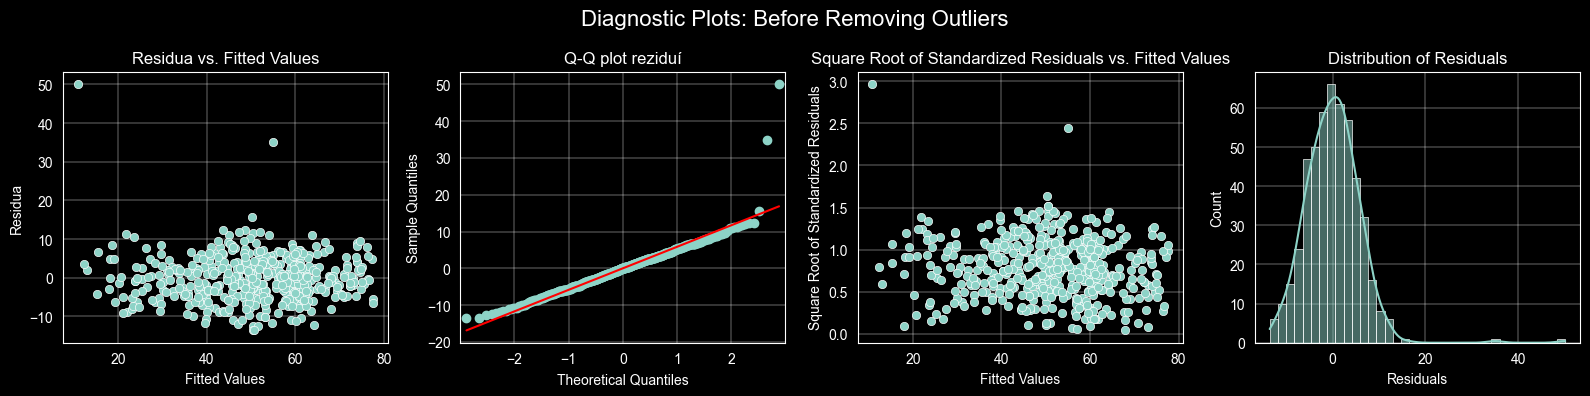

In [42]:
plot_diagnostic_subplots(model, title='Diagnostic Plots: Before Removing Outliers')

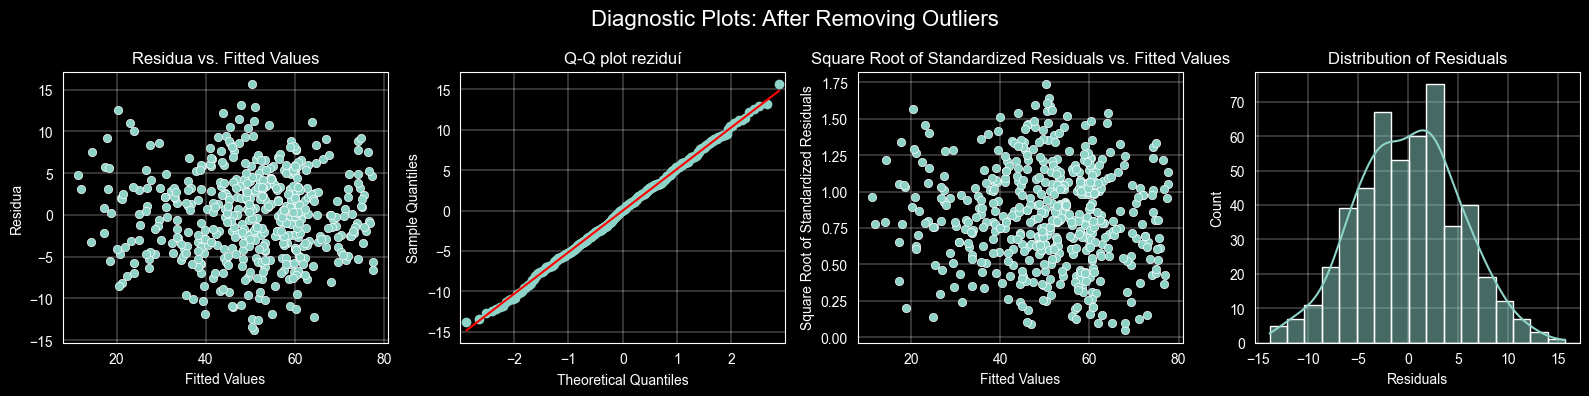

In [43]:
plot_diagnostic_subplots(model_without_outliers, title='Diagnostic Plots: After Removing Outliers')

## TASK 2.2. - Using your resulting model, identify for which parameter settings the response has the most problematic value. [1. points] 

In [44]:
# Find max ping value
max_ping = model_without_outliers.predict().argmax()
print(f"Highes ping value: {y[max_ping]:.5f}, index: {max_ping}")
print(f"For parameters: \n{poly_X.iloc[max_ping]}")

Highes ping value: 72.00000, index: 10
For parameters: 
const                         1.000000
ActiveUsers                   1.636436
InteractingPct                1.636444
iOS                           0.000000
MacOS                         1.000000
Android                       0.000000
ActiveUsers^2                 2.677922
ActiveUsers InteractingPct    2.677935
ActiveUsers MacOS             1.636436
ActiveUsers Android           0.000000
Name: 10, dtype: float64


## TASK 2.3 - Estimate the response value of a Windows user, averaging the other parameters, and calculate the confidence interval and prediction interval for this setting. [Points 1]

In [45]:
# Average values
mean_poly_X = poly_X.mean()

# Predict ping for user with Windows
predicted_ping = model_without_outliers.predict(mean_poly_X)
print(f"Predicted ping: {predicted_ping.values[0]:.5f}")

# Calculate confidence interval
confidence_interval = model_without_outliers.get_prediction(mean_poly_X).conf_int()

# Calculate prediction interval
prediction_interval = model_without_outliers.get_prediction(mean_poly_X).conf_int(obs=True)

# Print confidence and prediction interval
print(f"Confidenční interval: ({confidence_interval[0][0]:.5f}, {confidence_interval[0][1]:.5f})")
print(f"Predikční interval: ({prediction_interval[0][0]:.5f}, {prediction_interval[0][1]:.5f})")

Predicted ping: 50.44600
Confidenční interval: (49.98837, 50.90363)
Predikční interval: (40.20294, 60.68906)


In [46]:
model_without_outliers.params

const                         54.936395
ActiveUsers                    7.747412
InteractingPct                 5.151195
iOS                           -9.337293
MacOS                          5.342413
Android                       -3.663808
ActiveUsers^2                 -2.985642
ActiveUsers InteractingPct    -2.543882
ActiveUsers MacOS              6.734240
ActiveUsers Android            2.295054
dtype: float64

In [96]:
X1 = np.arange(0, 10000, 50)  # ActiveUsers
X2 = np.arange(0, 1, 0.005)  # InteractingPct

# Create meshgrid for X1 and X2
X1, X2 = np.meshgrid(X1, X2)

Y = (
        model_without_outliers.params['const'] +
        X1 * model_without_outliers.params['ActiveUsers'] +
        X2 * model_without_outliers.params['InteractingPct'] +
        model_without_outliers.params['iOS'] +
        model_without_outliers.params['MacOS'] +
        model_without_outliers.params['Android'] +
        X1 * X1 * model_without_outliers.params['ActiveUsers^2'] +
        X1 * model_without_outliers.params['ActiveUsers InteractingPct'] +
        X1 * model_without_outliers.params['ActiveUsers MacOS'] +
        X1 * model_without_outliers.params['ActiveUsers Android']
)

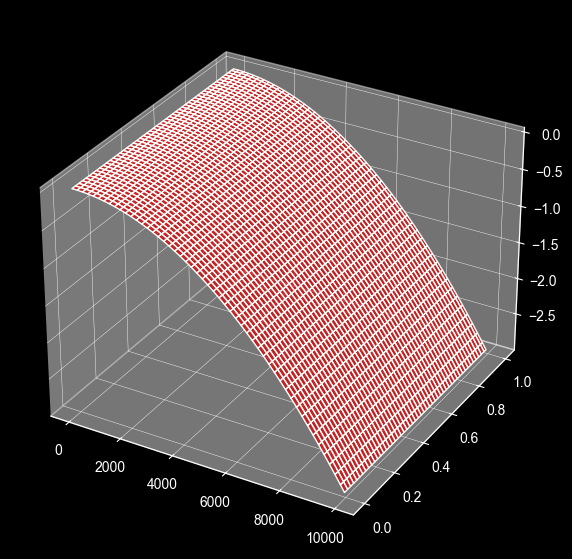

In [97]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7))
ax.plot_surface(X1, X2, Y, alpha=0.7, label="Windows", color='red')
plt.show()

In [50]:
base = (model_without_outliers.params['const'] +
        X1 * model_without_outliers.params['ActiveUsers'] +
        X2 * model_without_outliers.params['InteractingPct'] +
        X1 * X2 * model_without_outliers.params['ActiveUsers InteractingPct'] +
        X1 * X1 * model_without_outliers.params['ActiveUsers^2'])
windows = (base + X1 * model_without_outliers.params['ActiveUsers Windows'])
macos = (base + model_without_outliers.params['MacOS'])
ios = (base + X1 * model_without_outliers.params['ActiveUsers iOS'] + model_without_outliers.params['iOS'])
android = (base + model_without_outliers.params['Android'])

KeyError: 'ActiveUsers Windows'

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7))
ax.plot_surface(X1, X2, windows, alpha=0.7, label="Windows", color='red')
ax.plot_surface(X1, X2, macos, alpha=0.7, label="MacOS", color='blue')
ax.plot_surface(X1, X2, ios, alpha=0.7, label="iOS", color='green')
ax.plot_surface(X1, X2, android, alpha=0.7, label="Android", color='yellow')
ax.set(xlabel="ActiveUsers",
       ylabel="InteractingPct",
       zlabel="Ping")
ax.legend(loc="upper right")
plt.show()

## TASK 2.4. - Based on any calculated characteristics, argue whether your model is "suitable" for further use. [2. points]
